In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
sns.set_style("whitegrid")

## Reading Data

In [2]:
#layout file describing all columns
layout = pd.read_csv('public_layout.csv')

In [3]:
layout.head()

,Variable Name,Variable Label,Variable Order in File,Variable Type,Length
0,DOEID,Unique identifier for each respondent,1,Character,5
1,REGIONC,Census Region,2,Numeric,8
2,DIVISION,Census Division,3,Numeric,8
3,REPORTABLE_DOMAIN,Reportable states and groups of states,4,Numeric,8
4,TYPEHUQ,Type of housing unit,5,Numeric,8


In [8]:
layout.shape

(931, 5)

There are 931 columns total.

In [3]:
data = pd.read_csv('recs2009_public.csv')

In [4]:
data.shape

(12083, 931)

In [60]:
data.head()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEEL,KAVALNG,PERIODNG,SCALENG,PERIODLP,SCALELP,PERIODFO,SCALEFO,PERIODKR,SCALEKER
0,1,2,4,12,2,2471.679705,4742,1080,4953,1271,...,0,-2,-2,-2,-2,-2,-2,-2,-2,-2
1,2,4,10,26,2,8599.172010,2662,199,2688,143,...,0,1,1,0,-2,-2,-2,-2,-2,-2
2,3,1,1,1,5,8969.915921,6233,505,5741,829,...,0,3,5,3,-2,-2,-2,-2,-2,-2
3,4,2,3,7,2,18003.639600,6034,672,5781,868,...,3,3,5,3,-2,-2,-2,-2,-2,-2
4,5,1,1,1,3,5999.605242,5388,702,5313,797,...,0,1,1,0,-2,-2,-2,-2,-2,-2


In [4]:
#some useful functions for looking up data

def whatis(columns):
    #get column description
    #INPUT: columns - list of column names or a string of one column name
    try:
        for column in columns:
            print column,'=',layout.loc[layout['Variable Name'] == column,'Variable Label'].values[0]
    except:
        print columns,'=',layout.loc[layout['Variable Name'] == columns,'Variable Label'].values[0]

def search_columns(term):
    #search for columns contain term
    df = layout.loc[layout['Variable Label'].str.contains(term,case=False),['Variable Name','Variable Label']]
    return df

In [61]:
whatis('REGIONC')

R = REGIONC = Census Region


In [62]:
search_columns('Region')

,Variable Name,Variable Label
1,REGIONC,Census Region
10,Climate_Region_Pub,Building America Climate Region (collapsed for...


For this analysis, we are only interested in single-family houses. We are excluding apartments and mobile homes, so we need to remove those housing types. 

In [56]:
data['TYPEHUQ'].value_counts()

2    3752
5     858
3     479
4     311
1     286
Name: TYPEHUQ, dtype: int64

Single-family detached is type 2, and single-family attached is type 3. 

In [21]:
data = data[data['TYPEHUQ'].isin([2,3])]

In [22]:
data.shape

(8693, 931)

## Exploratory Data Analysis

Electricity usage

In [63]:
print 'Mean, Std:', data['KWH'].mean(), data['KWH'].std()

Mean, Std: 11288.1593975 7641.19084518


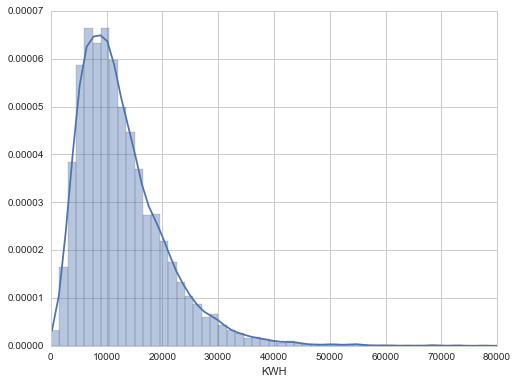

In [64]:
fig, ax = plt.subplots(figsize=[8,6])
ax.set_xlim(0,80000)
sns.distplot(data['KWH'],ax=ax, bins=100)

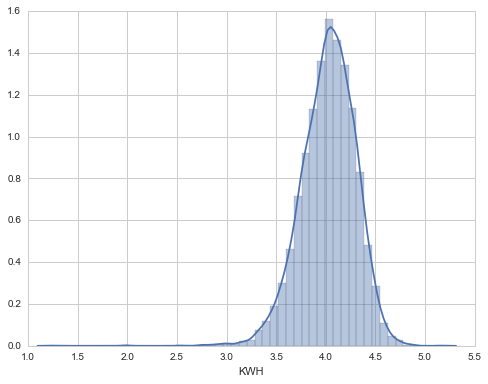

In [65]:
#Log plot
fig, ax = plt.subplots(figsize=[8,6])
#ax.set_xlim(0,80000)
sns.distplot(data['KWH'].map(math.log10),ax=ax)

Look for outliers in KWH.

In [66]:
#Looking for data with log(KWH) larger than 3 standard deviation from the mean.
log_kwh = data['KWH'].map(math.log10)
print 'Data > 3*Sigma:'
print data.loc[log_kwh > (log_kwh.mean()+3.*log_kwh.std()), 'KWH']

#Data with KWH larger than 60000
print 'Data > 60,000 KWH:'
print data.loc[data['KWH']>60000, 'KWH']

Data > 3*Sigma:
3551    150254
4839     72865
8112     77622
9129     72725
Name: KWH, dtype: int64
Data > 60,000 KWH:
1362      60183
3551     150254
4212      68382
4418      69007
4712      68289
4839      72865
8112      77622
9129      72725
10220     64232
Name: KWH, dtype: int64


There seem to be one entry with an unusually large KWH. Entry 3551. 

In [36]:
print 'SQRT:', data.loc[3551,'TOTSQFT_EN'], 'Rooms:', data.loc[3551,'TOTROOMS']

 SQRT: 9545 Rooms: 23


In [5]:
#Removing this entry
data = data.drop(3551)

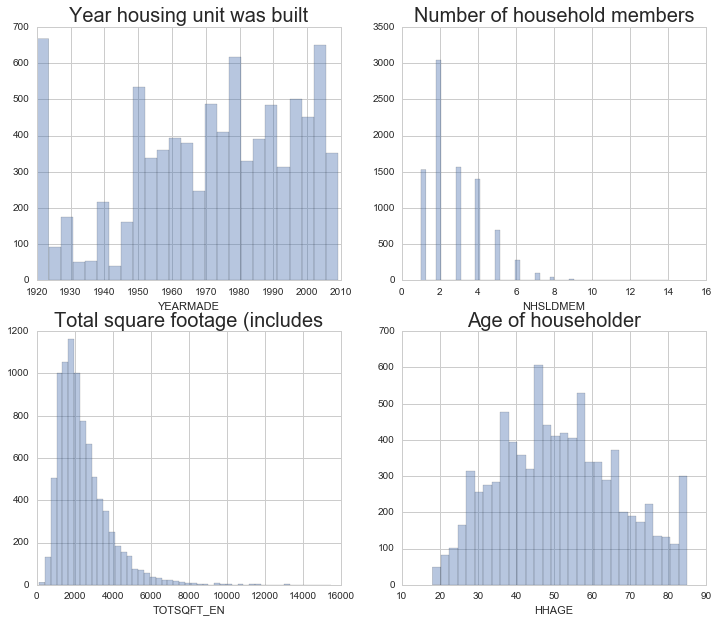

In [68]:
fig, axarr = plt.subplots(2,2,figsize=[12,10])
col = ['YEARMADE','NHSLDMEM','TOTSQFT_EN','HHAGE']
for i in range(4):
    axarr.flatten()[i].set_title(whatis(col[i])[:30],size=20)
    sns.distplot(data[col[i]],ax=axarr.flatten()[i],kde=False)


Some of these bins suggest some sensored data. For example, the year made started from 1920. Houses built prior to that year might be put as 1920. We can look at the imputation flag to see how many of these data points were imputed. Similarly for the age data.

In [69]:
data['ZYEARMADE'].value_counts()

0    7882
1     810
Name: ZYEARMADE, dtype: int64

In [70]:
data.loc[data['YEARMADE']==1920,'ZYEARMADE'].value_counts()

0    534
1     90
Name: ZYEARMADE, dtype: int64

Only about 15% were imputed. The number for 1920 is quite high. I wonder if this has something to do with the survey itself. We don't see any house that were built prior to 1920 eventhough the year range is reported to be 1600-2009. From the survey form, the participants were asked to fill in the estimate year the house was built.

Explore some other important features.

In [7]:
from sklearn.utils import resample

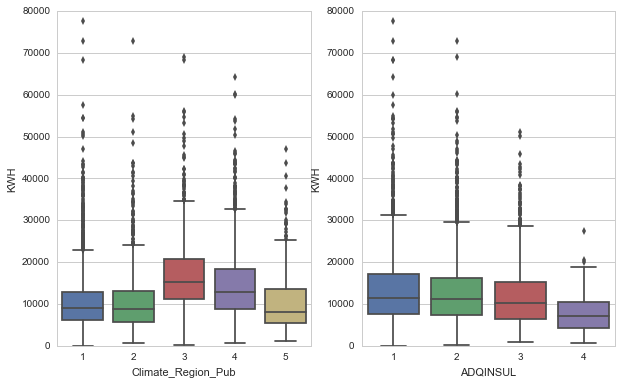

In [73]:
#Looking at some categorical features
fig, axarr = plt.subplots(1,2,figsize=[10,6])
sns.boxplot(ax=axarr[0],data=data,x='Climate_Region_Pub',y='KWH')
sns.boxplot(ax=axarr[1],data=data,x='ADQINSUL',y='KWH')

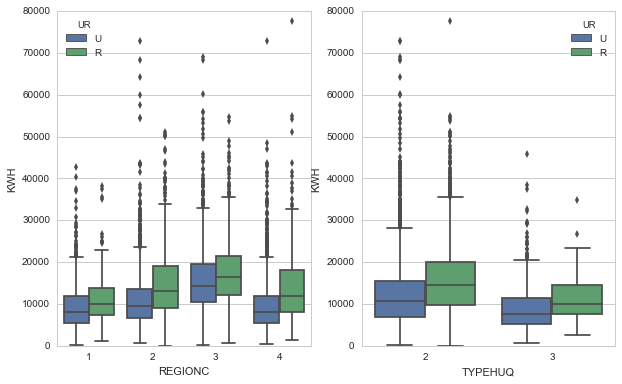

In [74]:
fig, axarr = plt.subplots(1,2,figsize=[10,6])
sns.boxplot(ax=axarr[0],data=data,x='REGIONC',y='KWH',hue='UR')
sns.boxplot(ax=axarr[1],data=data,x='TYPEHUQ',y='KWH',hue='UR')

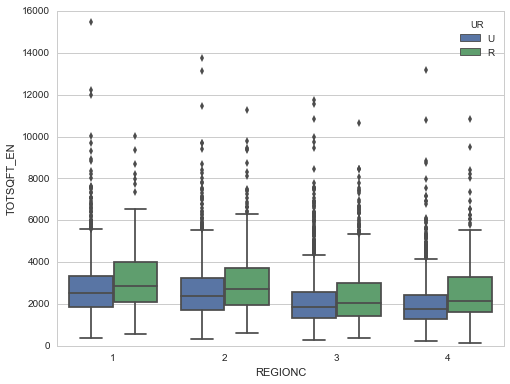

In [76]:
fig, ax = plt.subplots(figsize=[8,6])
sns.boxplot(ax=ax,data=data,x='REGIONC',y='TOTSQFT_EN',hue='UR')

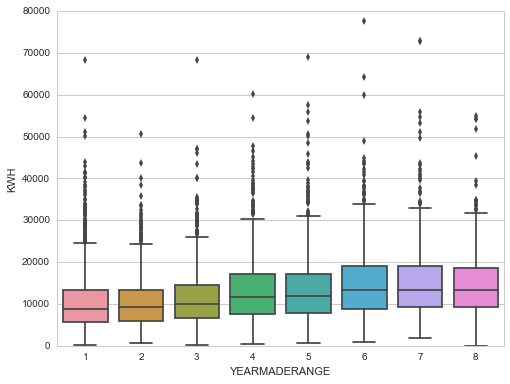

In [80]:
fig, ax = plt.subplots(figsize=[8,6])
sns.boxplot(ax=ax,data=data,x='YEARMADERANGE',y='KWH')

In [9]:
#Since we have more than 10k samples, we are resampling them for visualization purposes. 
subdata = resample(data, replace=False, n_samples= 1000, random_state=42)

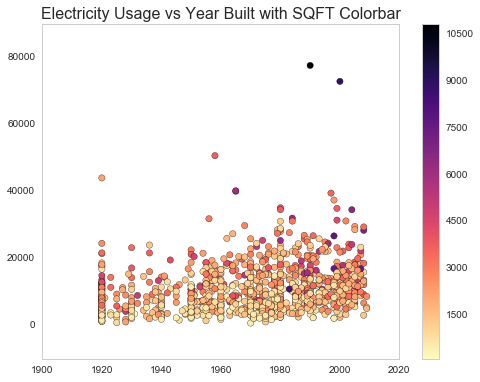

In [18]:
fig, ax = plt.subplots(figsize=[8,6])
ax.set_title('Electricity Usage vs Year Built with SQFT Colorbar',size=16)
ax.grid(b=False)
cax = ax.scatter(subdata['YEARMADE'],subdata['KWH'],c=subdata['TOTSQFT_EN'],cmap='magma_r',s=40)
cbar = fig.colorbar(cax)

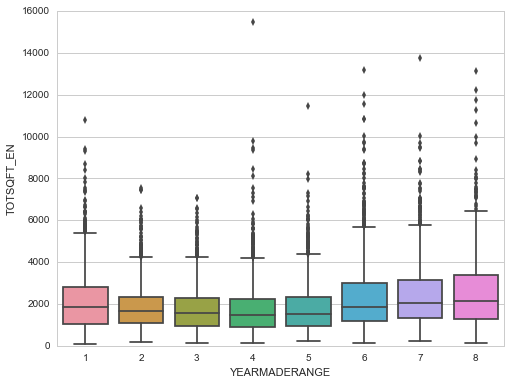

In [19]:
fig, ax = plt.subplots(figsize=[8,6])
sns.boxplot(ax=ax,data=data,x='YEARMADERANGE',y='TOTSQFT_EN')

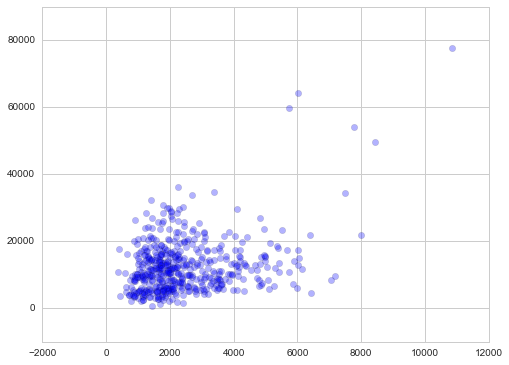

In [82]:
fig, ax = plt.subplots(figsize=[8,6])
ax.scatter(subdata['TOTSQFT_EN'],subdata['KWH'],s=40,alpha=0.3)

## Modeling

### Preprocessing

In [52]:
#function for calculating error
def rms_error(y_pred,y_true):
    se = (y_pred - y_true)**2
    mse = np.mean(se)
    return (se,math.sqrt(mse))
se_arr = {}
rmse = {}

Calculating Pearson correlation coefficient for the quantitative columns

In [7]:
from scipy.stats.stats import pearsonr

#Calculate and print the Pearson correlation coefficient and the coresponding p-values
def calculate_rho(df,quan_col):
    for col in quan_col:
        corcoef = pearsonr(df[col],data['KWH'])
        print "%s: %8.2f P-value: %8.2f" % (col,corcoef[0],corcoef[1])

Next, we will need to transform the categorical data into something that can be used in a model. Each categorical columns will need to be converted to multiple columns each corresponding to a single label with values of 1/0. We are dropping the first label for each column.

In [8]:
#Encoding Categorical data
def encode_qual(df,qual_col):
    return pd.get_dummies(df,columns=qual_col,prefix=qual_col,drop_first=True)

### Benchmarking: First Linear Regression Model

We will start with a simple linear regression model. How well can we predict electricity usage from few, main features? This will be our first benchmark.

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression

In [55]:
#selecting columns
quan_col = ['YEARMADE','NHSLDMEM','TOTSQFT_EN']
qual_col = ['Climate_Region_Pub','TYPEHUQ']
whatis(quan_col+qual_col)

YEARMADE = Year housing unit was built
NHSLDMEM = Number of household members
TOTSQFT_EN = Total square footage (includes heated/cooled garages, all basements, and finished/heated/cooled attics). Used for EIA data tables.
Climate_Region_Pub = Building America Climate Region (collapsed for public file)
TYPEHUQ = Type of housing unit


In [56]:
df = data[quan_col+qual_col]

In [57]:
df.count()

YEARMADE              12082
NHSLDMEM              12082
TOTSQFT_EN            12082
Climate_Region_Pub    12082
TYPEHUQ               12082
dtype: int64

In [58]:
#Convert categorical data
df = encode_qual(df,qual_col)

In [59]:
calculate_rho(df,quan_col)

YEARMADE:     0.22 P-value:     0.00
NHSLDMEM:     0.28 P-value:     0.00
TOTSQFT_EN:     0.38 P-value:     0.00


All the correlation coefficients are positive but not very large. All of the p-values are less than 0.01. They are all significant (using the confidence level of 0.05), which is to be expected considering the large number of samples we have.  

Try a very simplistic linear model to see how well it does. 

In [60]:
X = df.values
y = data['KWH'].values
X.shape, y.shape

((12082, 11), (12082,))

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LinearRegression()
clf.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [62]:
print 'Train set r^2:', clf.score(X_train,y_train)
print 'Test set r^2:', clf.score(X_test,y_test)

Train set r^2: 0.343592341801
Test set r^2: 0.339263493732


In [63]:
f_value, p_value = f_regression(X,y.flatten())

In [64]:
for i in xrange(len(f_value)):
    print df.columns[i],'F-value:',"%6.0f" % f_value[i],' P-value:',"%5.2f" % p_value[i]
    

YEARMADE F-value:    606  P-value:  0.00
NHSLDMEM F-value:   1011  P-value:  0.00
TOTSQFT_EN F-value:   1997  P-value:  0.00
Climate_Region_Pub_2 F-value:    181  P-value:  0.00
Climate_Region_Pub_3 F-value:    636  P-value:  0.00
Climate_Region_Pub_4 F-value:    204  P-value:  0.00
Climate_Region_Pub_5 F-value:     61  P-value:  0.00
TYPEHUQ_2 F-value:   1464  P-value:  0.00
TYPEHUQ_3 F-value:     84  P-value:  0.00
TYPEHUQ_4 F-value:    324  P-value:  0.00
TYPEHUQ_5 F-value:   1034  P-value:  0.00


In [65]:
se_arr['BM_SLR'], rmse['BM_SLR'] = rms_error(clf.predict(X_test),y_test)

In [66]:
rmse['BM_SLR']

6086.678797133355

### Benchmarking: Ridge Regression

In [67]:
from sklearn.linear_model import Ridge

In [33]:
clf = Ridge(alpha=1)
clf.fit(X_train,y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [34]:
clf.score(X_test,y_test)

0.33927220095566835

### Feature Selection

In [68]:
from sklearn.feature_selection import SelectKBest

In [101]:
house_categ = ['REGIONC','DIVISION','REPORTABLE_DOMAIN','TYPEHUQ','Climate_Region_Pub','AIA_Zone',
              'METROMICRO','UR','KOWNRENT','CONDCOOP','WALLTYPE','ROOFTYPE','FUELHEAT','COOLTYPE',
              'USECENAC','FUELPOOL','TYPEGLASS','ADQINSUL','PELHEAT','PELAC']
house_quant = ['HDD65','CDD65','HDD30YR','CDD30YR','YEARMADE','STORIES','BEDROOMS','NCOMBATH','NHAFBATH',
              'OTHROOMS','TOTROOMS','ACROOMS','NUMBERAC','DOOR1SUM','WINDOWS','TOTSQFT_EN','TOTHSQFT','TOTCSQFT']
house_bin = ['CELLAR','CRAWL','CONCRETE','BASEFIN','BASEHEAT','BASECOOL','ATTIC','ATTICFIN','ATTCHEAT',
            'ATTCCOOL','GARGHEAT','PROTHERM','DUCTS','CENACHP','PROTHERMAC','HIGHCEIL','CATHCEIL','POOL',
             'HEATHOME','ELWARM','ELCOOL','ELWATER','ONSITE']

mem_quant = ['NHSLDMEM','HHAGE','MONEYPY']
mem_bin = ['HUPROJ','ATHOME']

In [102]:
df = data[house_categ+house_quant+house_bin+mem_quant+mem_bin]

In [103]:
#Encoding Categorical data
df = pd.get_dummies(df,columns=house_categ,prefix=house_categ,drop_first=True)

In [104]:
df.shape

(12082, 152)

In [105]:
X = df.values
y = data['KWH'].values

#### Removing Outliers

In [21]:
from sklearn.ensemble import IsolationForest

In [41]:
IF = IsolationForest(contamination=0.01)
IF.fit(X)
anomaly = IF.predict(X)

IsolationForest(bootstrap=False, contamination=0.01, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0)

In [45]:
anomaly[np.where(anomaly==-1)].size/float(anomaly.size)

0.01001489819566297

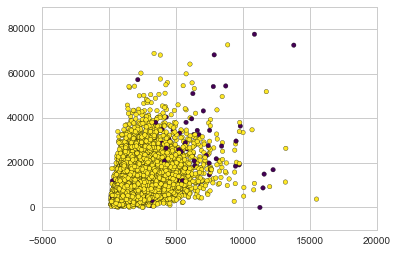

In [46]:
plt.scatter(df['TOTSQFT_EN'],y,c=anomaly,cmap='viridis')

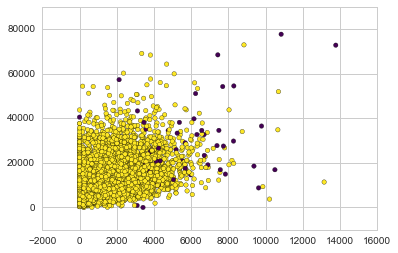

In [47]:
plt.scatter(df['TOTCSQFT'],y,c=anomaly,cmap='viridis')

#### Selecting Features

In [74]:
#Using SelectKBest to calculate f-value and p-value for each feature
KBest = SelectKBest(f_regression,k=50)
KBest.fit(X,y)

SelectKBest(k=50, score_func=<function f_regression at 0x121669500>)

In [75]:
#Create a Dataframe to store KBest result
KBest_df = pd.DataFrame(index=df.columns)
KBest_df['score'] = KBest.scores_
KBest_df['p_value'] = KBest.pvalues_
KBest_df = KBest_df.sort_values(by='score',ascending=False)

In [106]:
KBest_df.head(10)

,score,p_value
TOTCSQFT,3649.077658,0.0
ACROOMS,2820.767832,0.0
TOTROOMS,2811.157650,0.0
NCOMBATH,2508.198236,0.0
TOTHSQFT,2399.812919,0.0
BEDROOMS,2370.632732,0.0
TOTSQFT_EN,1996.783256,0.0
CENACHP,1900.086844,0.0
USECENAC_3,1688.132420,0.0
OTHROOMS,1644.210999,0.0


Creating a train and test sets for the rest of the analysis. We want to keep this test set seperated and not do any CV on it. 

In [107]:
#order the columns by f-score
df = df[KBest_df.index]

#create a train and test sets
X = df.values
y = data['KWH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [108]:
X_train.shape, y_train.shape

((9665, 152), (9665,))

In [79]:
#Compare models with k features
k_list = range(5,150,5) 
train_score = []
test_score = []

for k in k_list:
    #Need to evaluate on a CV set, so wee need to split the training set again
    X_CV_train, X_CV_test, y_CV_train, y_CV_test = train_test_split(
                X_train[:,:k], y_train, test_size=0.3, random_state=34)
    clf = LinearRegression()
    clf.fit(X_CV_train,y_CV_train)
    train_score.append(clf.score(X_CV_train,y_CV_train))
    test_score.append(clf.score(X_CV_test,y_CV_test))
    

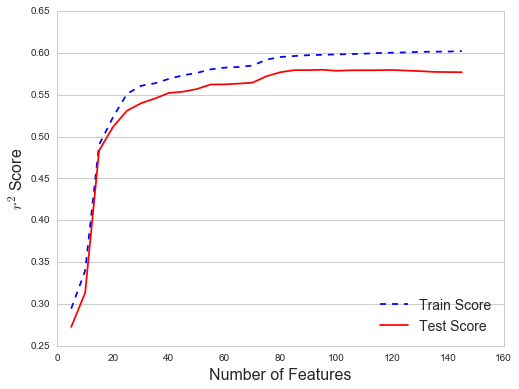

In [111]:
#plot the scores
fig, ax = plt.subplots(figsize=[8,6])
ax.set_xlabel('Number of Features',size=16)
ax.set_ylabel('$r^2$ Score',size=16)
ax.xaxis.grid(b=False)
ax.plot(k_list,train_score,'b--',label='Train Score')
ax.plot(k_list,test_score,'r-',label='Test Score')
ax.legend(loc=4,fontsize=14)

In [80]:
k_best = k_list[np.argmax(test_score)]
print 'Maximum test score:', max(test_score),' with',k_best,'features'

Maximum test score: 0.579779647518  with 95 features


Select k_best features from the data.

In [109]:
X_train = X_train[:,:k_best]
X_test = X_test[:,:k_best]
df = df.iloc[:,:k_best]
X_train.shape, X_test.shape

((9665, 95), (2417, 95))

### Fitting Linear Regression

In [95]:
#on test data
clf = LinearRegression()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.55708181216708474

In [97]:
se_arr['SLR'], rmse['SLR'] = rms_error(clf.predict(X_test),y_test)

In [98]:
rmse['SLR']

4983.425726558976

In [31]:
residual = y_test - clf.predict(X_test)

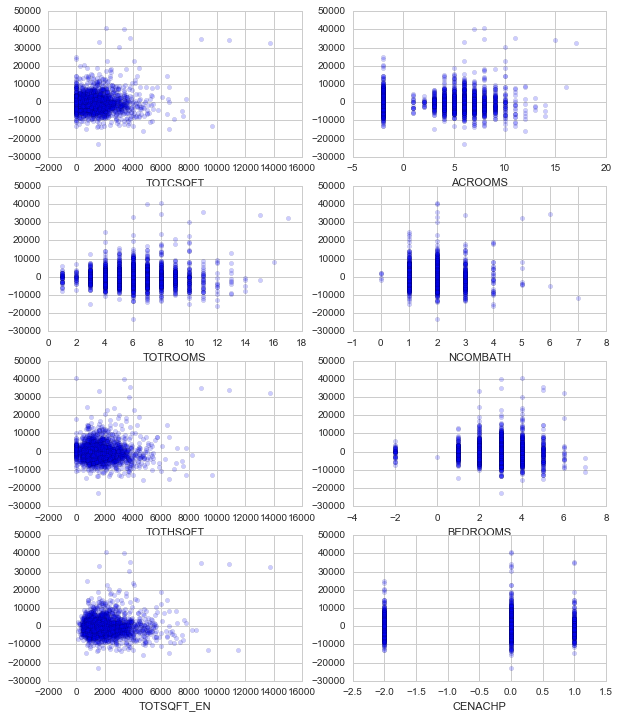

In [32]:
fig, axarr = plt.subplots(4,2,figsize=[10,12])

for i in range(8):
    axarr.flatten()[i].set_xlabel(KBest_df.index[i])
    axarr.flatten()[i].scatter(X_test[:,i],residual,alpha=0.2)

### Lasso

In [118]:
from sklearn.linear_model import Lasso

In [133]:
clf = Lasso(alpha=4)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.5579716405959011

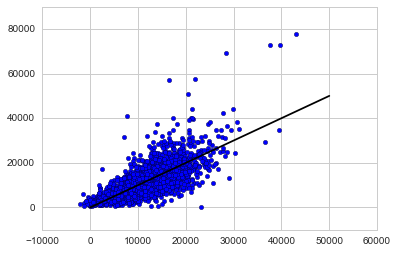

In [136]:
plt.scatter(clf.predict(X_test),y_test)
plt.plot([0,50000],[0,50000],'k-')

### Random Forest

In [111]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [124]:
#CV 
n_features = k_best
params = {'max_features': np.linspace(math.sqrt(n_features),n_features,num=10,dtype='int'),
         'min_samples_leaf': range(1,20,5),
         'max_depth':range(2,7)}
clf = RandomForestRegressor(n_estimators=15)
CV = GridSearchCV(clf, param_grid=params)
CV.fit(X_train,y_train)
CV.best_params_

{'max_depth': 6, 'max_features': 38, 'min_samples_leaf': 1}

In [125]:
clf = RandomForestRegressor(max_features=CV.best_params_['max_features'],
                           min_samples_leaf=CV.best_params_['min_samples_leaf'])
clf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=38, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [126]:
print clf.score(X_train,y_train)
print clf.score(X_test,y_test)

0.921671998381
0.515454467787


In [116]:
scores = []
for n in xrange(1,30,4):
    clf = RandomForestRegressor(n_estimators=n,
        max_features=CV.best_params_['max_features'],
        min_samples_leaf=CV.best_params_['min_samples_leaf'])
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))

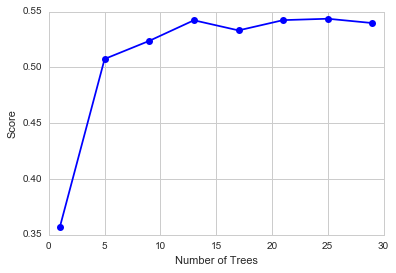

In [117]:
fig, ax = plt.subplots()
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Score')
plt.plot(xrange(1,30,4),scores,'bo-')

In [121]:
print 'Train set r^2:', clf.score(X_train,y_train)
print 'Test set r^2:', clf.score(X_test,y_test)

Train set r^2: 0.775778017398
Test set r^2: 0.540311914208


In [122]:
feat_imp = pd.DataFrame(index=df.columns)
feat_imp['imp'] = clf.feature_importances_

In [123]:
feat_imp.sort_values(by='imp', ascending=False)

,imp
TOTCSQFT,0.157272
ACROOMS,0.097377
ELWATER,0.096484
FUELHEAT_5,0.081764
TOTROOMS,0.058644
NHSLDMEM,0.050233
BEDROOMS,0.041064
POOL,0.037971
TOTHSQFT,0.037535
TOTSQFT_EN,0.037084
